<a href="https://colab.research.google.com/github/costalferz/Leaf-Disease-Classification-Augment/blob/main/DSI444_70_15_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# License: BSD

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
# from PIL import Image
from tempfile import TemporaryDirectory
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
print(torch.__version__)
print(torchvision.__version__)
!python --version

2.0.1+cu118
0.15.2+cu118
Python 3.10.12


# Download Data_NO Augment

In [ ]:
!curl -L -o roboflow.zip "https://app.roboflow.com/ds/jcFfz9CvlR?key=OZ6mrOsC6S" && unzip roboflow.zip -d Data_NO_Augment && rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   894  100   894    0     0   2525      0 --:--:-- --:--:-- --:--:--  2532
100 13.9M  100 13.9M    0     0  21.1M      0 --:--:-- --:--:-- --:--:-- 21.1M
Archive:  roboflow.zip
 extracting: Data_NO_Augment/README.dataset.txt  
 extracting: Data_NO_Augment/README.roboflow.txt  
   creating: Data_NO_Augment/test/
   creating: Data_NO_Augment/test/AlgalLeafSpot/
 extracting: Data_NO_Augment/test/AlgalLeafSpot/AlgalLeafSpot001_jpg.rf.e9d6a7c422062d35475812d4c0cd6104.jpg  
 extracting: Data_NO_Augment/test/AlgalLeafSpot/AlgalLeafSpot004_jpg.rf.1d22d39bd18e19f4defe579697b66499.jpg  
 extracting: Data_NO_Augment/test/AlgalLeafSpot/AlgalLeafSpot013_jpg.rf.236e6a67951a5ecee25c410c0d998e34.jpg  
 extracting: Data_NO_Augment/test/AlgalLeafSpot/AlgalLeafSpot036_jpg.rf.0c2d5959a5e45dba0cd8ee39964646db.jpg  
 extracting: Data_NO_Augment/tes

#Download Data Augment

In [ ]:
# !curl -L -o roboflow.zip "https://app.roboflow.com/ds/8Hw98Eauea?key=xIrYoWnUZ4" && unzip roboflow.zip -d Data_Augment && rm roboflow.zip

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/content/Data_NO_Augment'
# data_dir = '/content/Data_Augment'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,shuffle=True, num_workers=2)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_sizes

{'train': 158, 'valid': 33}

In [ ]:
print(dataloaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7a6e978aea70>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x7a6e978aff70>}


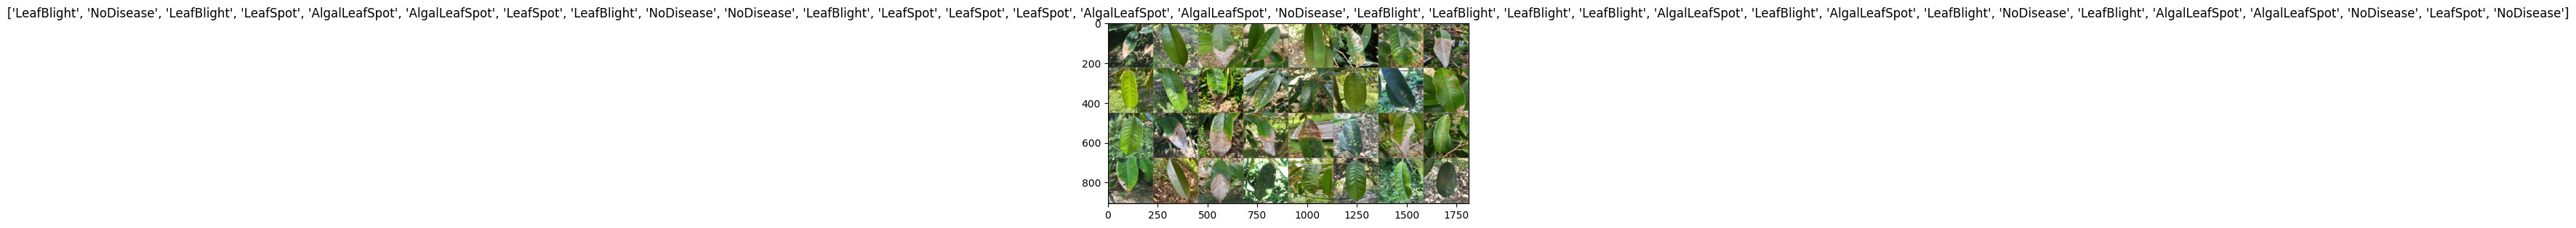

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'valid' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

# ResNet18

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 60.5MB/s]


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler_ft,
                       num_epochs=75)

Epoch 0/74
----------
train Loss: 1.2506 Acc: 0.4304
valid Loss: 0.8099 Acc: 0.6364

Epoch 1/74
----------
train Loss: 0.3243 Acc: 0.9430
valid Loss: 0.2141 Acc: 0.9394

Epoch 2/74
----------
train Loss: 0.0626 Acc: 0.9937
valid Loss: 0.0905 Acc: 0.9697

Epoch 3/74
----------
train Loss: 0.0068 Acc: 1.0000
valid Loss: 0.0178 Acc: 1.0000

Epoch 4/74
----------
train Loss: 0.0042 Acc: 1.0000
valid Loss: 0.0170 Acc: 1.0000

Epoch 5/74
----------
train Loss: 0.0010 Acc: 1.0000
valid Loss: 0.0266 Acc: 1.0000

Epoch 6/74
----------
train Loss: 0.0005 Acc: 1.0000
valid Loss: 0.0318 Acc: 1.0000

Epoch 7/74
----------
train Loss: 0.0005 Acc: 1.0000
valid Loss: 0.0393 Acc: 1.0000

Epoch 8/74
----------
train Loss: 0.0002 Acc: 1.0000
valid Loss: 0.0380 Acc: 1.0000

Epoch 9/74
----------
train Loss: 0.0003 Acc: 1.0000
valid Loss: 0.0378 Acc: 1.0000

Epoch 10/74
----------
train Loss: 0.0002 Acc: 1.0000
valid Loss: 0.0422 Acc: 1.0000

Epoch 11/74
----------
train Loss: 0.0007 Acc: 1.0000
valid Loss

# VGG16

In [ ]:
# Initialize VGG16 model
model_vgg = models.vgg16(weights='IMAGENET1K_V1')

# Replace the final fully connected layer with a new one for your task
model_vggs = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(model_vggs, len(class_names))

# Ensure that the model is on the desired device (e.g., GPU)
model_vgg = model_vgg.to(device)

# Define your loss function (e.g., CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# Define your optimizer (e.g., SGD with momentum)
optimizer_vgg = optim.SGD(model_vgg.parameters(), lr=0.01, momentum=0.9)

# Define a learning rate scheduler
exp_lr_scheduler_vgg = lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 90.0MB/s]


In [ ]:
model_vgg = train_model(model_vgg, criterion, optimizer_vgg, exp_lr_scheduler_vgg,
                       num_epochs=75)

Epoch 0/74
----------
train Loss: 1.3503 Acc: 0.3924
valid Loss: 0.8323 Acc: 0.8182

Epoch 1/74
----------
train Loss: 0.8589 Acc: 0.7468
valid Loss: 1.3822 Acc: 0.3030

Epoch 2/74
----------
train Loss: 1.4726 Acc: 0.3038
valid Loss: 1.7052 Acc: 0.2727

Epoch 3/74
----------
train Loss: 1.5616 Acc: 0.2468
valid Loss: 1.4205 Acc: 0.1515

Epoch 4/74
----------
train Loss: 7.3986 Acc: 0.3038
valid Loss: 70.2743 Acc: 0.2727

Epoch 5/74
----------
train Loss: nan Acc: 0.2152
valid Loss: nan Acc: 0.2727

Epoch 6/74
----------
train Loss: nan Acc: 0.2595
valid Loss: nan Acc: 0.2727

Epoch 7/74
----------
train Loss: nan Acc: 0.2595
valid Loss: nan Acc: 0.2727

Epoch 8/74
----------
train Loss: nan Acc: 0.2595
valid Loss: nan Acc: 0.2727

Epoch 9/74
----------
train Loss: nan Acc: 0.2595
valid Loss: nan Acc: 0.2727

Epoch 10/74
----------
train Loss: nan Acc: 0.2595
valid Loss: nan Acc: 0.2727

Epoch 11/74
----------
train Loss: nan Acc: 0.2595
valid Loss: nan Acc: 0.2727

Epoch 12/74
-------

#EfficientNet_b2

In [ ]:
model_ef = models.efficientnet_b2(weights='IMAGENET1K_V1')
model_ef = model_ef.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ef = optim.SGD(model_ef.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_ef = lr_scheduler.StepLR(optimizer_ef, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 206MB/s] 


In [ ]:
model_ef = train_model(model_ef, criterion, optimizer_ef, exp_lr_scheduler_ef,
                       num_epochs=75)

Epoch 0/74
----------
train Loss: 7.0780 Acc: 0.0063
valid Loss: 6.2563 Acc: 0.0000

Epoch 1/74
----------
train Loss: 3.4883 Acc: 0.4747
valid Loss: 1.8677 Acc: 0.6364

Epoch 2/74
----------
train Loss: 0.6813 Acc: 0.9304
valid Loss: 0.9257 Acc: 0.7576

Epoch 3/74
----------
train Loss: 0.1064 Acc: 0.9810
valid Loss: 0.3947 Acc: 0.8788

Epoch 4/74
----------
train Loss: 0.0162 Acc: 1.0000
valid Loss: 0.2199 Acc: 0.9091

Epoch 5/74
----------
train Loss: 0.0094 Acc: 1.0000
valid Loss: 0.1344 Acc: 0.9394

Epoch 6/74
----------
train Loss: 0.0044 Acc: 1.0000
valid Loss: 0.0860 Acc: 0.9394

Epoch 7/74
----------
train Loss: 0.0256 Acc: 0.9873
valid Loss: 0.0584 Acc: 0.9697

Epoch 8/74
----------
train Loss: 0.0034 Acc: 1.0000
valid Loss: 0.0566 Acc: 0.9697

Epoch 9/74
----------
train Loss: 0.0037 Acc: 1.0000
valid Loss: 0.0516 Acc: 1.0000

Epoch 10/74
----------
train Loss: 0.0009 Acc: 1.0000
valid Loss: 0.0546 Acc: 1.0000

Epoch 11/74
----------
train Loss: 0.0301 Acc: 0.9937
valid Loss

In [ ]:
from sklearn.metrics import f1_score
model_factory = [model_ft,
                 model_vgg,
                 model_ef
                 ]
true_labels = []
predicted_labels = []
correct = 0
total = 0

for model in model_factory:
  model.eval()  # Set the model to evaluation mode
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      true_labels.extend(labels.cpu().numpy())
      predicted_labels.extend(predicted.cpu().numpy())

  accuracy = correct / total
  f1 = f1_score(true_labels, predicted_labels, average='weighted')  # 'weighted' accounts for class imbalance
  print(f'Accuracy: {100 * accuracy:.2f}%')
  print(f'F1 Score: {f1:.4f}')
  print("\n")

Accuracy: 100.00%
F1 Score: 1.0000


Accuracy: 90.91%
F1 Score: 0.9096


Accuracy: 93.94%
F1 Score: 0.9397




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

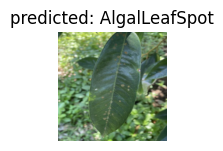

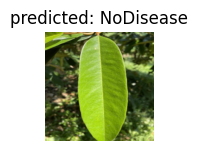

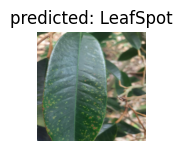

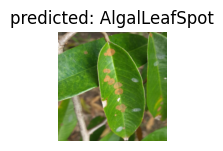

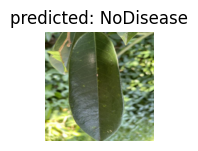

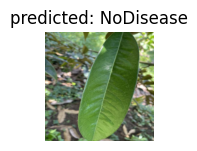

In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

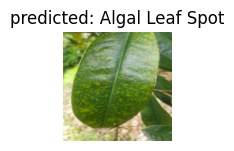

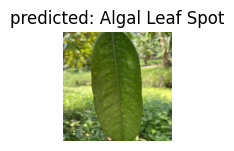

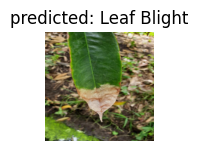

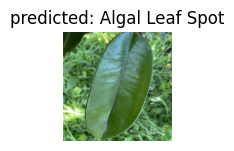

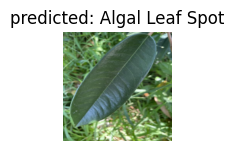

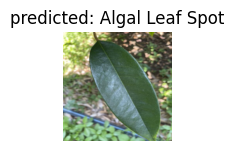

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()